In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from preprocess import make_dataset
import torch.optim as optim
from model import *
from torch.utils.data import Dataset, DataLoader


/home/zwx/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self, IR_dataset, distance_dataset, ground_truth, filename_dataset):
        self.IR_dataset = IR_dataset
        self.distance_dataset = distance_dataset
        self.ground_truth = ground_truth
        self.filename_dataset = filename_dataset

    def __len__(self):
        return len(self.IR_dataset)

    def __getitem__(self, idx):
        IR_data = self.IR_dataset[idx]
        distance_data = self.distance_dataset[idx]
        label = self.ground_truth[idx]
        # 将标签转换为one-hot编码
        label_one_hot = torch.zeros(LABEL_NUM)
        label_one_hot[label] = 1
        return IR_data, distance_data, label_one_hot, self.filename_dataset[idx]


In [3]:
# 转换为PyTorch张量并缩放数据
def scale_IR(dataset):
    tensor = torch.tensor(dataset, dtype=torch.float32)
    max_val = 35. # tensor.max()
    min_val = 15. # tensor.min()
    scaled_tensor = (tensor - min_val) / (max_val - min_val)
    return scaled_tensor, max_val, min_val



In [4]:
sampled_distance_dataset, sampled_IR_dataset, groudtruth, sampled_filename_dataset = make_dataset()
# 示例数据转换
distance_tensor = torch.tensor(np.stack(sampled_distance_dataset, axis=0), dtype=torch.float32)
IR_tensor, max_IR, min_IR = scale_IR(np.stack(sampled_IR_dataset, axis=0))


distance length is 375
IR length is 375
gt length is 375
Distance dataset 1: 224, (14, 2)
IR dataset 1: 224, (9, 64)
gt dataset 1: 224
filename dataset 1: 224
Distance dataset 2: 224, (14, 2)
IR dataset 2: 224, (9, 64)
gt dataset 2: 224
filename dataset 2: 224


In [5]:

# 创建数据集和数据加载器
dataset = CustomDataset(IR_tensor, distance_tensor, groudtruth, sampled_filename_dataset)
# dataloader = DataLoader(dataset, batch_size=BATCH, shuffle=True)


In [6]:
from torch.utils.data import random_split

# 随机分割训练集和测试集，假设80%为训练集，20%为测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


In [7]:

# 实例化网络
net = MyMLP().cuda()
# net = MyCNN().cuda()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [8]:
loss_history = []
# 训练循环示例
for epoch in range(1500):
    running_loss = 0.0
    for i, (IR_data, distance_data, labels, _) in enumerate(train_dataloader, 0):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()
        labels = labels.cuda()
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(IR_data, distance_data)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()

        # 打印统计信息
        running_loss += loss.cpu().item()
        if i % 20 == 19:  # 每10个批次打印一次
            loss_mean = running_loss / 20
            loss_history.append(loss_mean)
            print(f"[{epoch + 1}, {i + 1}] loss: {loss_mean:.3f}")
            running_loss = 0.0


[1, 20] loss: 1.610
[2, 20] loss: 1.606
[3, 20] loss: 1.595
[4, 20] loss: 1.600
[5, 20] loss: 1.566
[6, 20] loss: 1.558
[7, 20] loss: 1.550
[8, 20] loss: 1.507
[9, 20] loss: 1.496
[10, 20] loss: 1.486
[11, 20] loss: 1.491
[12, 20] loss: 1.440
[13, 20] loss: 1.440
[14, 20] loss: 1.427
[15, 20] loss: 1.384
[16, 20] loss: 1.405
[17, 20] loss: 1.400
[18, 20] loss: 1.441
[19, 20] loss: 1.427
[20, 20] loss: 1.366
[21, 20] loss: 1.418
[22, 20] loss: 1.403
[23, 20] loss: 1.394
[24, 20] loss: 1.425
[25, 20] loss: 1.346
[26, 20] loss: 1.381
[27, 20] loss: 1.425
[28, 20] loss: 1.389
[29, 20] loss: 1.363
[30, 20] loss: 1.385
[31, 20] loss: 1.391
[32, 20] loss: 1.360
[33, 20] loss: 1.365
[34, 20] loss: 1.386
[35, 20] loss: 1.379
[36, 20] loss: 1.351
[37, 20] loss: 1.427
[38, 20] loss: 1.381
[39, 20] loss: 1.333
[40, 20] loss: 1.380
[41, 20] loss: 1.339
[42, 20] loss: 1.395
[43, 20] loss: 1.390
[44, 20] loss: 1.364
[45, 20] loss: 1.386
[46, 20] loss: 1.370
[47, 20] loss: 1.330
[48, 20] loss: 1.404
[

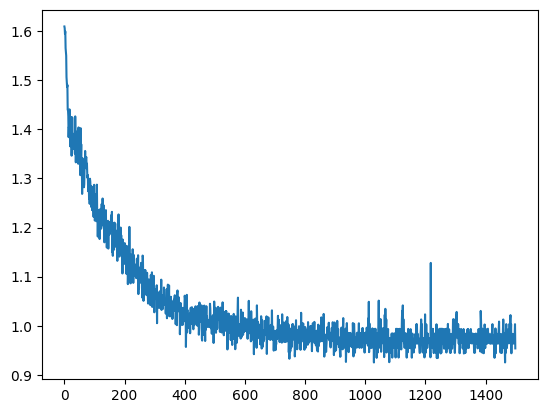

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 测试循环
true_labels = []
predicted_labels = []
filenames = []
with torch.no_grad():
    for i, (IR_data, distance_data, labels, filename) in enumerate(test_dataloader):
        IR_data = IR_data.cuda()
        distance_data = distance_data.cuda()

        outputs = net(IR_data, distance_data)
        outputs = outputs.cpu()

        _, predicted = torch.max(outputs.data, 1)
        _, gt = torch.max(labels.data, 1)
        
        true_labels.extend(gt.numpy())
        predicted_labels.extend(predicted.numpy())
        filenames += filename

# 计算性能指标
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1) # macro
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}\n")

# 计算每个类别的精确度和召回率
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)

# 打印结果
print("labels are ", ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit'])
print(f"Precision per class: {precision_per_class}")
print(f"Recall per class: {recall_per_class}\n")

from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

print("混淆矩阵:")
print(cm)

Accuracy: 0.8444
Precision: 0.8622
Recall: 0.8444

labels are  ['idle', 'sit', 'sit2stand', 'stand', 'stand2sit']
Precision per class: [1.         1.         0.77777778 0.66666667 0.8       ]
Recall per class: [1.         0.71428571 0.77777778 1.         0.72727273]

混淆矩阵:
[[12  0  0  0  0]
 [ 0  5  1  0  1]
 [ 0  0  7  1  1]
 [ 0  0  0  6  0]
 [ 0  0  1  2  8]]


In [11]:
# 找出被错误分类的样本
misclassified_samples = [filenames[i] for i in range(len(filenames)) if true_labels[i] != predicted_labels[i]]
print("被错误分类的样本:", misclassified_samples)

被错误分类的样本: ['low-positon-stand2sit_1711695869', 'low-positon-stand2sit_1711949851', 'low-positon-stand2sit_1711694811', 'low-position-sit_1711701438', 'low-position-sit2stand_1711693945', 'low-position-sit2stand_1711692627', 'low-position-sit_1711692359']


In [12]:
import shutil
import os
from datetime import datetime
from pathlib import Path

# 创建目标文件夹
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
target_folder = os.path.join("wrongs", timestamp)
os.makedirs(target_folder, exist_ok=True)

# 复制被错误分类的样本到目标文件夹
for filename in misclassified_samples:
    # 假设原始文件位于当前文件夹中
    source_path = Path('..') / 'data' / filename.split('_')[0] / f'{filename}.mp4'
    # target_path = os.path.join(target_folder, os.path.basename(filename))
    shutil.copy(source_path, target_folder)

print(f"被错误分类的样本已复制到 {target_folder}")


被错误分类的样本已复制到 wrongs/20240406-210334


In [13]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

Total parameters: 3389


In [14]:
torch.save(net.state_dict(), 'checkpoints/low/F9-14-MLP221-Fea4-24-gap32-0d86.pth')